In [1]:
## AUXILIAR: IMPORTS GLOBALES
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import cross_val_predict, GridSearchCV, KFold
from sklearn.metrics import r2_score, root_mean_squared_error, mean_absolute_error

In [2]:
## AUXILIAR: Muestra los resultados de cada modelo.

def show_results(objetivo_real, objetivo_predicho, title):
    print(f"\n{title}:")
    print(f"R²  : {r2_score(objetivo_real, objetivo_predicho):.3f}")
    print(f"RMSE: {root_mean_squared_error(objetivo_real, objetivo_predicho):.3f}")
    print(f"MAE : {mean_absolute_error(objetivo_real, objetivo_predicho):.3f}")

In [3]:
# Carga de datos
dataset = pd.read_csv('../datasets/carprices.csv')

#### LIMPIEZA
Se revisan tipos, nulos y duplicados para asegurar consistencia del dataset.

Se imputan numéricas con mediana (robusta a outliers) y categóricas con moda (categoría representativa) para no perder filas.

In [5]:
# Análisis Exploratorio.

print("\nInfo general del dataset:")
dataset.head()
dataset.info()

print("\nValores faltantes por atributo:")
print(dataset.isnull().sum().sort_values(ascending=False))

print("\nFilas duplicadas:")
print(dataset.duplicated().sum())


Info general del dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11914 entries, 0 to 11913
Data columns (total 16 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Make               11914 non-null  object 
 1   Model              11914 non-null  object 
 2   Year               11914 non-null  int64  
 3   Engine Fuel Type   11911 non-null  object 
 4   Engine HP          11845 non-null  float64
 5   Engine Cylinders   11884 non-null  float64
 6   Transmission Type  11914 non-null  object 
 7   Driven_Wheels      11914 non-null  object 
 8   Number of Doors    11908 non-null  float64
 9   Market Category    8172 non-null   object 
 10  Vehicle Size       11914 non-null  object 
 11  Vehicle Style      11914 non-null  object 
 12  highway MPG        11914 non-null  int64  
 13  city mpg           11914 non-null  int64  
 14  Popularity         11914 non-null  int64  
 15  MSRP               11914 non-null  int64  


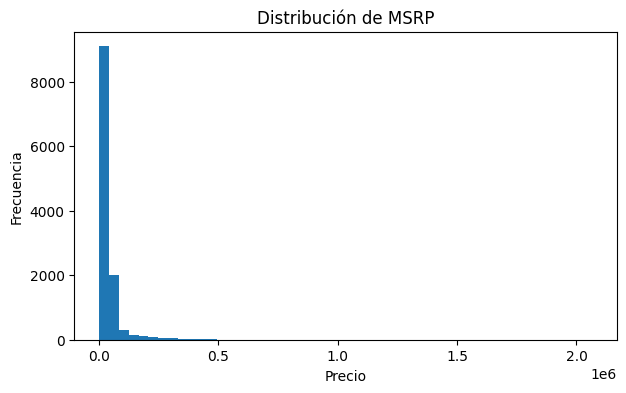

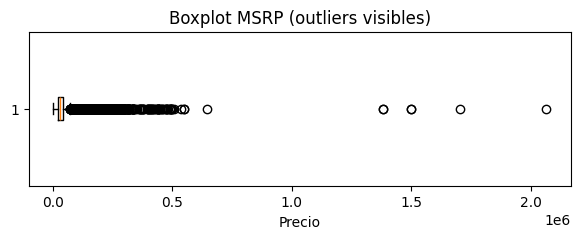

In [92]:
# Análisis de distribución

"""
Se analiza la distribución de la variable objetivo (MSRP)
y si hay presencia de outliers en la misma.
"""

columna = dataset["MSRP"]

# Gráfico de barras para ver distribución de MSRP
plt.figure(figsize=(7,4))
plt.hist(columna, bins=50)
plt.title("Distribución de MSRP")
plt.xlabel("Precio")
plt.ylabel("Frecuencia")
plt.show()

# Gráfico boxplot para ver mejor los outliers
plt.figure(figsize=(7,2))
plt.boxplot(columna, vert=False, showfliers=True)
plt.title("Boxplot MSRP (outliers visibles)")
plt.xlabel("Precio")
plt.show()

In [93]:
# Imputación.

""" 
Se proceden a imputar los valores nulos de los atributos del dataset.
- Para atributos continuos, se utilizará la mediana.
- Para atributos categóricos, se utilizará la moda.

- El atributo Market Category no se va a imputar, sino eliminar directamente,
dado que contiene muchos valores nulos que si se imputaran generaría ruído,
sumando a que es un atributo con muchos valores posibles y no tan significativo.
"""

# Columnas numéricas.
numeric_cols = ['Engine HP', 'Engine Cylinders', 'Number of Doors']

for columna in numeric_cols:
    mediana = dataset[columna].median()
    dataset[columna] = dataset[columna].fillna(mediana)

# Columnas categóricas.
categoric_cols = ['Engine Fuel Type']

for columna in categoric_cols:
    moda = dataset[columna].mode()[0]
    dataset[columna] = dataset[columna].fillna(moda)

# Verificación.
print("\nValores faltantes por atributo:")
print(dataset.isnull().sum())


Valores faltantes por atributo:
Make                    0
Model                   0
Year                    0
Engine Fuel Type        0
Engine HP               0
Engine Cylinders        0
Transmission Type       0
Driven_Wheels           0
Number of Doors         0
Market Category      3742
Vehicle Size            0
Vehicle Style           0
highway MPG             0
city mpg                0
Popularity              0
MSRP                    0
dtype: int64


#### INTEGRACIÓN
No se requirió integración: el análisis se realizó con un único CSV consistente.

Si en el futuro se incorporan varias fuentes, acá se resolvía el join y la reconciliación de claves.

#### SELECCIÓN
Se descartan atributos poco útiles o redundantes para simplificar y evitar colinealidad.

Se mide correlación entre pares (city vs highway mpg, cylinders vs HP) y se eliminan columnas muy correlacionadas/solapadas, de alta cardinalidad o poco informativas.

Esto reduce ruido y estabiliza el entrenamiento, especialmente en modelos lineales.

In [94]:
# Análisis de correlación

city_mpg_col = dataset["city mpg"]
highway_mpg_col = dataset["highway MPG"]

engine_cylinders_col = dataset["Engine Cylinders"]
engine_hp_col = dataset["Engine HP"]

# Calcular correlaciones lineales (Pearson) entre pares de variables
corr_city_hwy = city_mpg_col.corr(highway_mpg_col, method="pearson")
corr_cylinders_hp   = engine_cylinders_col.corr(engine_hp_col, method="pearson")

print(f"Correlación entre 'City MPG' y 'Highway MPG': {corr_city_hwy:.3f}")
print(f"Correlación entre 'Engine Cylinders' y 'Engine HP': {corr_cylinders_hp:.3f}")

Correlación entre 'City MPG' y 'Highway MPG': 0.887
Correlación entre 'Engine Cylinders' y 'Engine HP': 0.767


In [95]:
# Eliminación
cols_a_eliminar = [
    "Market Category",    # demasiados valores nulos, muchas categorías, no es útil y genera ruido
    "Model",              # demasiadas categorías, redundante con Make
    "Vehicle Size",       # redundante, no aporta información nueva respecto a otras variables
    "Engine Cylinders",   # muy correlacionada con potencia (HP)
    "city mpg",           # muy correlacionada con highway MPG
]

dataset = dataset.drop(columns=cols_a_eliminar)

# Verificación
dataset.head()

,Make,Year,Engine Fuel Type,Engine HP,Transmission Type,Driven_Wheels,Number of Doors,Vehicle Style,highway MPG,Popularity,MSRP
0,BMW,2011,premium unleaded (required),335.0,MANUAL,rear wheel drive,2.0,Coupe,26,3916,46135
1,BMW,2011,premium unleaded (required),300.0,MANUAL,rear wheel drive,2.0,Convertible,28,3916,40650
2,BMW,2011,premium unleaded (required),300.0,MANUAL,rear wheel drive,2.0,Coupe,28,3916,36350
3,BMW,2011,premium unleaded (required),230.0,MANUAL,rear wheel drive,2.0,Coupe,28,3916,29450
4,BMW,2011,premium unleaded (required),230.0,MANUAL,rear wheel drive,2.0,Convertible,28,3916,34500


#### TRANSFORMACIÓN
Se convierte el dato al formato que requieren los algoritmos:
- Se agrupa Engine Fuel Type en una variable más estable (Fuel Group) para reducir ruido de categorías muy similares.
- Se codifican las variables categóricas con One-Hot Encoding.

El escalado se realiza dentro de los pipelines y solo con el train para evitar data leakage.

In [96]:
"""
- Se agrupan tipos de combustible a una nueva variable Fuel Group.

Se aplica una transformación numérica con One Hot Encoding para atributos categóricos multiclase,
que será realizada en los respectivos training set para evitar data leakage.
"""

# Analizar posibles valores antes de agrupar
conteo_combustible = dataset["Engine Fuel Type"].value_counts().sort_values(ascending=False)
print("Cantidad de filas por tipo de combustible:\n")
print(conteo_combustible)

# Agrupar combustible a grupos generales
def agrupar_combustible(value: str) -> str:
    v = str(value).lower()

    if "premium" in v:
        return "Premium"
    if "regular" in v or "gasoline" in v or "petrol" in v:
        return "Regular"
    if "flex" in v or "diesel" in v or "electric" in v or "natural" in v:
        return "Especial"

    return "Especial"

# Agrupar los valores de Engine Fuel Type en 'Premium', 'Regular' o 'Especial'
combustible_values = dataset["Engine Fuel Type"].apply(agrupar_combustible)

# Crear la nueva columna Fuel Group con los valores generados y eliminar la columna Engine Fuel Type.
dataset["Fuel Group"] = combustible_values
dataset = dataset.drop(columns=["Engine Fuel Type"])

# Verificación
dataset.head()


Cantidad de filas por tipo de combustible:

Engine Fuel Type
regular unleaded                                7175
premium unleaded (required)                     2009
premium unleaded (recommended)                  1523
flex-fuel (unleaded/E85)                         899
diesel                                           154
electric                                          66
flex-fuel (premium unleaded required/E85)         54
flex-fuel (premium unleaded recommended/E85)      26
flex-fuel (unleaded/natural gas)                   6
natural gas                                        2
Name: count, dtype: int64


,Make,Year,Engine HP,Transmission Type,Driven_Wheels,Number of Doors,Vehicle Style,highway MPG,Popularity,MSRP,Fuel Group
0,BMW,2011,335.0,MANUAL,rear wheel drive,2.0,Coupe,26,3916,46135,Premium
1,BMW,2011,300.0,MANUAL,rear wheel drive,2.0,Convertible,28,3916,40650,Premium
2,BMW,2011,300.0,MANUAL,rear wheel drive,2.0,Coupe,28,3916,36350,Premium
3,BMW,2011,230.0,MANUAL,rear wheel drive,2.0,Coupe,28,3916,29450,Premium
4,BMW,2011,230.0,MANUAL,rear wheel drive,2.0,Convertible,28,3916,34500,Premium


In [97]:
"""
Se aplica un escalado con StandardScaler() para los atributos continuos.
Este escalado se aplica en el training set al momento de hacer el split, y no
en todo el dataset dado que provoca filtración de data y eso puede sesgar las métricas
de los modelos (el test set gana información sobre el training set que no debería saber).
"""

""" 
Se aplica codificación con One Hot Encoding para los atributos categóricos multiclase.
Esta codificación se aplica en el training set al momento de hacer el split, y no
en todo el dataset dado que provoca filtración de data y eso puede sesgar las métricas
de los modelos (el test set gana información sobre el training set que no debería saber).
"""

' \nSe aplica codificación con One Hot Encoding para los atributos categóricos multiclase.\nEsta codificación se aplica en el training set al momento de hacer el split, y no\nen todo el dataset dado que provoca filtración de data y eso puede sesgar las métricas\nde los modelos (el test set gana información sobre el training set que no debería saber).\n'

#### MINERÍA Y EVALUACIÓN
Se entrenan y comparan modelos usando dos enfoques:
- Cross-validation.
- Cross-validation + Grid search.

Se reportan las siguientes métricas:
- R² (coeficiente de determinación, refleja cómo el modelo capta la varianza/dispersión de los valores).
- RMSE (error típico penalizando errores grandes).
- MAE (error promedio absoluto, robusto a outliers).

In [98]:
## REGRESIÓN LINEAL:

""" 
Se genera un pipeline el cual procura que el modelo ESCALE los valores continuos
y realice las transformaciones con One Hot Encoding SOLO en cada training set, 
esto evita que haya filtrado de data en el test set y el modelo dé métricas un poco sesgadas.
"""

categoric_cols = ["Make", "Driven_Wheels", "Vehicle Style", "Transmission Type", "Fuel Group"]
numeric_cols = [column for column in dataset.columns if column not in categoric_cols + ["MSRP"]]

pipe_LR = Pipeline([
    ("preprocess", ColumnTransformer([
        ("continuos", StandardScaler(), numeric_cols),
        ("categoricos", OneHotEncoder(drop="first", handle_unknown="ignore"), categoric_cols)
    ])),
    ("modelo", LinearRegression())
])

In [99]:
## Regresión lineal Cross-validation

atributos = dataset.drop(columns="MSRP")
objetivo = dataset["MSRP"]

# Cross-validation K Fold
cv5 = KFold(n_splits=5, shuffle=True, random_state=42)

objetivo_predicho = cross_val_predict(
    estimator=pipe_LR,
    X=atributos,
    y=objetivo,
    cv=cv5,
    n_jobs=-1
)

# Evaluar resultados
show_results(objetivo, objetivo_predicho, title="Regresión Lineal - Cross-validation")


Regresión Lineal - Cross-validation:
R²  : 0.826
RMSE: 25088.907
MAE : 9877.343


In [100]:
## RANDOM FOREST:

"""
Se genera un pipeline que mantiene el mismo patrón que en Regresión Lineal.
En Random Forest el escalado no es necesario, pero el One Hot Encoding sí
lo sigue siendo.
"""

categoric_cols = ["Make", "Driven_Wheels", "Vehicle Style", "Transmission Type", "Fuel Group"]
numeric_cols = [column for column in dataset.columns if column not in categoric_cols + ["MSRP"]]

pipe_RF = Pipeline([
    ("preprocess", ColumnTransformer([
        ("continuos", "passthrough", numeric_cols),
        ("categoricos", OneHotEncoder(drop="first", handle_unknown="ignore"), categoric_cols)
    ])),
    ("modelo", RandomForestRegressor(random_state=42))
])

In [101]:
## Primera iteración: Random Forest Cross-validation

atributos = dataset.drop(columns="MSRP")
objetivo = dataset["MSRP"]

# Cross-validation K Fold
cv5 = KFold(n_splits=5, shuffle=True, random_state=42)

objetivo_predicho = cross_val_predict(
    estimator=pipe_RF,
    X=atributos,
    y=objetivo,
    cv=cv5,
    n_jobs=-1
)

# Evaluar resultados
show_results(objetivo, objetivo_predicho, title="Random Forest - Cross-validation")


Random Forest - Cross-validation:
R²  : 0.934
RMSE: 15444.145
MAE : 3666.012


In [102]:
## Segunda iteración: Random Forest Cross-validation + Grid Search

# Hiperparámetros a probar con Grid Search
parametros_RF = {
    "modelo__n_estimators": [100, 200],
    "modelo__max_depth": [5, 10, 20],
    # "modelo__n_estimators": [50, 100, 150, 200, 250, 300],
    # "modelo__max_depth": [5, 10, 15, 20, 25, 30],
    # "modelo__min_samples_split": [2, 5, 10],
    # "modelo__min_samples_leaf": [1, 2, 4],
    # "modelo__max_features": ["sqrt", "log2", None]
}

# Cross-validation K Fold
cv5 = KFold(n_splits=5, shuffle=True, random_state=42)

# Grid search
grid_RF = GridSearchCV(
    estimator=pipe_RF,
    param_grid=parametros_RF,
    scoring="r2",
    cv=cv5,
    return_train_score=False,
    n_jobs=-1
)

# Ajuste con el training
grid_RF.fit(atributos, objetivo)
print("Mejor combinación de hiperparámetros [Random Forest]:")
print(grid_RF.best_params_)

# Modelo optimizado
mejor_RF = grid_RF.best_estimator_

objetivo_predicho = cross_val_predict(
    estimator=mejor_RF,
    X=atributos,
    y=objetivo,
    cv=cv5,
    n_jobs=-1
)

# Evaluar resultados
show_results(objetivo, objetivo_predicho, title="Random Forest - Cross-validation + Grid Search")

Mejor combinación de hiperparámetros [Random Forest]:
{'modelo__max_depth': 20, 'modelo__n_estimators': 100}

Random Forest - Cross-validation + Grid Search:
R²  : 0.934
RMSE: 15468.468
MAE : 3631.620
